# Spacer graph interface (used as LTS log file example)

This is not very super useful, just a small studied example of a web GUI, a log file and the final handout for the purpose of improving research reproducibility. Something I did not mention is that the functionality of the notebook can be expanded with extensions (example: drag and drops, advanced editing toolboxes, TOCs), but it is better not to use them at all in this introductory example and have a more basic and clean notebook.

### A get things done box:

TODO:
- Investigate why graphs containing so many spacers and flankers can be so tiny.

NEXT:
- Wait for LTS feedback

DONE:
- Make an introduction
- Add the crispr statistics script from the log files.
- Add the spacer graph display script.
- Present the widgets.
- Make a search and display box
- Assemble the code outside
- Load the code into the notebook and test
- Publish this on BitBucket and link into the Jupyter guide.


### Making an introduction

CRISPRs are chains of unique spacer sequences flanked by highly conserved direct repeats. The spacers are resulted from a prokaryotic cell interaction with a viral pathogen. In Andersson_2016 project we try to identify CRISPR regions in metagenomes using a program named Crass. The program churns the reads looking for direct repeats flanking a spacer sequence. It then assembles a graph, in which the nodes are spacer sequences and the linkage is made based on identified direct repeats. The program installation and run was documented elsewhere, and scripts were made for investigating the results and plotting the graphs. In this notebook we want to document making a tiny GUI interface, code assembly ouside the notebook and loading/running the external program.

In [ ]:
from IPython.core.display import HTML
HTML('<iframe src=https://en.wikipedia.org/wiki/CRISPR width=700 height=350>')

### Add the crispr statistics script from the log files.


In [3]:
%matplotlib inline
import os
os.chdir("/home/sergiun/projects/andersson/src/andersson/")
import subprocess
from io import StringIO
import pandas as pd
cmd = "crisprtools stat -aH ./data/test/crass.crispr"
p = subprocess.run(cmd.split(), stdout=subprocess.PIPE)
fbuff = StringIO(p.stdout.decode('utf-8'))
df = pd.read_csv(fbuff, sep="\t")
df.sort_values('# Flankers', ascending = 0, inplace = 1)

How the above script works is not important. To see more details visit the log page at [crisprtools.ipynb](crisprtools.ipynb).

In [4]:
df.head()

,GID,DR concensus,# DR Variants,Ave. DR Length,# spacers,Ave. SP Length,Ave. SP Cov,# Flankers,Ave. FL Length,# Reads
55,55,*,55,39,362,26,1,30,18,0
37,G37640,AGGGAGTAGAATCGAGGGTTATATGTCCATATATGGTAATAA,1,42,34,29,1,4,30,0
38,G37658,AGGGAGTAGAATCGAGGGTTATACGTCCATATATGGTAATAAT,1,43,17,26,1,3,28,0
3,G1525,AGTATAGCGATTCAGAAATCGAGGTCCAGACACAACT,1,37,24,28,1,2,30,0
42,G65807,CAAAAAAGTGTCTTCCGGGCTAATTGCAATTATTGTTGGTTG,1,42,3,32,1,2,34,0


We can use the table to sort out spacer groups. The spacer groups are resulted from single linkage clustering of the identified direct repeats. It may be from a species or an individual, but since this is metagenomics data it is hard to be sure.

Before we move on, we need to implement some query mechanism too. (I actually returned here from the code assembly, but as I specified in the Jupyter guide, it is better to follow the logic workflow rather than a time line).

In [ ]:
v = 'G37640'
q = df[df.GID == v]
if q.shape[0]>0 and q.shape[0]<2:
    print(v,q.iloc[0,1])
    

In [ ]:
q

In order for you to reproduce these results without installing project related programs, I am also saving the dataframe.

In [ ]:
df.to_csv('data/test/crispr.df.csv')
df2 = pd.read_csv('data/test/crispr.df.csv', index_col = 0)
df2.head()

### Add the spacer graph display script

Let us display one such spacer graph. The details are at [crass_fulltest.ipynb](crass_fulltest.ipynb) including a nicer graph plot, but we are again less interested in that. So this script can plot the spacer graph for a given GID ...

In [ ]:
import pygraphviz
import networkx as nx
from networkx.drawing.nx_agraph import read_dot
import matplotlib.pyplot as plt

G = read_dot("data/test/Spacers_1432_GTATTGGCCCCCTTTAAATTGTGGGGCAACTGAAACTA_spacers.gv")
plt.figure(figsize=(10,10), facecolor="w", frameon=False)
pos=nx.spring_layout(G)
offset = .05
pos_labels = {}
keys = pos.keys()
for key in keys:
    x, y = pos[key]
    pos_labels[key] = (x, y+offset)

node_colors = [ G.node[key]['fillcolor'] for key in G.node ]
nx.draw_networkx_nodes(G, pos, node_size=1200, node_shape='o', node_color=node_colors)
nx.draw_networkx_edges(G, pos, width=2, edge_color='b')
nx.draw_networkx_labels(G, pos_labels, fontsize=2)
#plt.show()
#plt.savefig('test.png')

### Widget presentation

The purpose of this notebook is to get an elegant functionality, and elegant displays use some form of GUI. We will use this: [https://github.com/ipython/ipywidgets](https://github.com/ipython/ipywidgets). The page contains many examples, so it is easy to fabricate something for your needs.

Here is a slider example.

In [ ]:
from ipywidgets import *
from IPython.display import display
w = IntSlider()
display(w)

### Make a search and display box

In [ ]:
tb = widgets.Text(
    description='GID:',
    value='',
)
bt = widgets.Button(description='Search')

HBox([tb, bt])

In [ ]:
tb.value

Awesome, now some event.

In [ ]:
def on_button_clicked(b):
    print("Button clicked. Value", tb.value)

bt.on_click(on_button_clicked)

Clicking the button above will now display the text. I have all I need to insert the proper functionality. Except that it didn't work when I assembled the code, until I figured out that I have to dispatch the display call on my layout box.

In [ ]:
tb = widgets.Text(
    description='GID:',
    value='',
)
bt = widgets.Button(description='Search')
box = HBox([tb, bt])
display(box)
def on_button_clicked(b):
    print("Button clicked. Value", tb.value)

bt.on_click(on_button_clicked)

### Assembly the code

While I normally do this on a code editor, I will make the assembly here this time then copy paste it into a source file. I am also changing the locations of some files, so this will break backward compatibility with the log files.  Log files are not important to maintain in terms of reproducible, they increase reproducibility by having a verbose workflow. Handouts though must insure reproducible data access as well. It falls out of our current scope.

In [2]:

%pylab inline

import os
os.chdir("/home/sergiun/projects/andersson/src/andersson/src/")
import subprocess
from io import StringIO
import pandas as pd
import pygraphviz
import networkx as nx
from networkx.drawing.nx_agraph import read_dot
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

def get_crispr_df_4real(v):
    cmd = "crisprtools stat -aH ../data/test/crass.crispr"
    p = subprocess.run(cmd.split(), stdout=subprocess.PIPE)
    fbuff = StringIO(p.stdout.decode('utf-8'))
    df = pd.read_csv(fbuff, sep="\t")
    q = df[df.GID == v]
    seq = None
    if q.shape[0]>0 and q.shape[0]<2:
        seq = q.iloc[0,1]
    return seq

def get_crispr_df_4fun(v):
    df = pd.read_csv('../data/test/crispr.df.csv', index_col = 0)
    q = df[df.GID == v]
    seq = None
    if q.shape[0]>0 and q.shape[0]<2:
        seq = q.iloc[0,1]
    return seq

def plot_spacer_graph(gid, seq):
    G = read_dot("../data/test/Spacers_"+gid[1:]+"_"+seq+"_spacers.gv")
    plt.figure(figsize=(10,10), facecolor="w", frameon=False)
    pos=nx.spring_layout(G)
    offset = .05
    pos_labels = {}
    keys = pos.keys()
    for key in keys:
        x, y = pos[key]
        pos_labels[key] = (x, y+offset)

    node_colors = [ G.node[key]['fillcolor'] for key in G.node ]
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_shape='o', node_color=node_colors)
    nx.draw_networkx_edges(G, pos, width=2, edge_color='b')
    nx.draw_networkx_labels(G, pos_labels, fontsize=2)
    plt.show()
    return

tb = widgets.Text(
    description='GID:',
    value='',
)
bt = widgets.Button(description='Search')
box = HBox([tb, bt])
display(box)
def on_button_clicked(b):
    print("Searching for", tb.value)
    seq = get_crispr_df_4fun(tb.value)
    if not seq==None:
        plot_spacer_graph(tb.value, seq)
    else:
        print('No spacer graph found!')
bt.on_click(on_button_clicked)

Populating the interactive namespace from numpy and matplotlib
Searching for G37640


OSError: File b'../data/test/crispr.df.csv' does not exist

And now, the long awaited moment of scientific discovery. It seems the number of spacers and flankers is not a good indicator for graph size, probably because they are collapsed based on similarity.

***TODO: investigate this further!***

### Load the code into the notebook and test

So now we want to place the code above in a source file and call it remotely. There are different ways to do this, I will show only one for the time being, probably the uggliest too. But also the easiest.

In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Searching for G37640


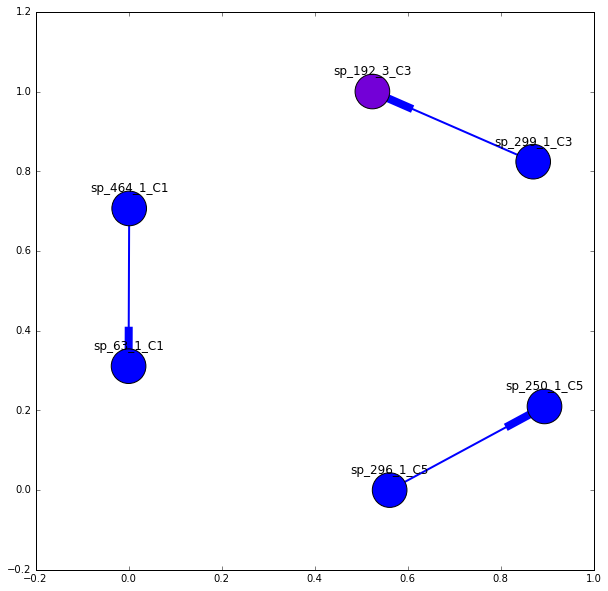

In [5]:
##%run /home/sergiun/projects/andersson/src/andersson/src/graph_retrieval.py

import os
os.chdir('/home/sergiun/projects/andersson/src/andersson/src/')
import graph_retrieval as gr
gr.search_box()

Worked like a trojan! The notebook can also be used as an OS terminal, a console to multiple languages, and an editor. Here follow a few examples:

In [21]:
help(gr.plot_spacer_graph_by_ID)
!ls ./

Help on function plot_spacer_graph_by_ID in module graph_retrieval:

plot_spacer_graph_by_ID(crispr_path, graph_path, gid)
    Plots the spacer graph on a Jupyter notebook.
    :param crispr_path: Path to the .crispr file.
    :param graph_path: Path to the directory containing the spacer graphs.
    :param gid: The group id of the spacer graph.
    :return:

configure_test.yaml  graph_retrieval.py  __init__.py  pipeline.py  __pycache__


In [ ]:
# %load graph_retrieval.py
import os
import subprocess
from io import StringIO
import pandas as pd
# import pygraphviz
import networkx as nx
from networkx.drawing.nx_agraph import read_dot
import matplotlib.pyplot as plt


def get_crispr_df(fsource):
    cmd = "crisprtools stat -aH " + fsource
    p = subprocess.run(cmd.split(), stdout=subprocess.PIPE)
    fbuff = StringIO(p.stdout.decode('utf-8'))
    df = pd.read_csv(fbuff, sep="\t")
    return df


def get_crispr_df_4fun(v):
    df = pd.read_csv('../data/test/crispr.df.csv', index_col=0)
    q = df[df.GID == v]
    seq = None
    if 0 < q.shape[0] < 2:
        seq = q.iloc[0, 1]
    return seq


def draw_graph(dot_fpath):
    G = read_dot(dot_fpath)
    plt.figure(figsize=(10, 10), facecolor="w", frameon=False)
    pos = nx.spring_layout(G)
    offset = .05
    pos_labels = {}
    keys = pos.keys()
    for key in keys:
        x, y = pos[key]
        pos_labels[key] = (x, y + offset)

    node_colors = [G.node[key]['fillcolor'] for key in G.node]
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_shape='o', node_color=node_colors)
    nx.draw_networkx_edges(G, pos, width=2, edge_color='b')
    nx.draw_networkx_labels(G, pos_labels, fontsize=2)
    return


def plot_spacer_graph(dpath, gid, seq):
    dot_fpath = dpath + "Spacers_" + gid[1:] + "_" + seq + "_spacers.gv"
    draw_graph(dot_fpath)
    plt.show()
    return


def plot_spacer_graph_by_ID(crispr_path, graph_path, gid):
    """
    Plots the spacer graph on a Jupyter notebook.
    :param crispr_path: Path to the .crispr file.
    :param graph_path: Path to the directory containing the spacer graphs.
    :param gid: The group id of the spacer graph.
    :return:
    """
    df = get_crispr_df(crispr_path)
    q = df[df.GID == gid]
    seq = None
    if 0 < q.shape[0] < 2:
        seq = q.iloc[0, 1]
        plot_spacer_graph(graph_path, gid, seq)
    else:
        print("The graph", gid, "could not be identified on the .crispr file!")
    return


def save_spacer_graph(dpath, gid, seq, dout):
    dot_fpath = dpath + "Spacers_" + gid[1:] + "_" + seq + "_spacers.gv"
    if os.path.isfile(dot_fpath):
        draw_graph(dot_fpath)
        plt.savefig(dout + gid + '.png')
        plt.close("all")  # clearing the RAM
        print("Graph", gid, "saved at", dout)
    else:
        print("File not found at", dot_fpath)
    return


def search_box():
    import ipywidgets as ipyw
    from IPython.display import display
    tb = ipyw.widgets.Text(
        description='GID:',
        value='G37640',
    )
    tbpath = ipyw.widgets.Text(
        description='Path:',
        value='../data/test/',
    )
    bt = ipyw.widgets.Button(description='Search')
    box = ipyw.HBox([tb, tbpath, bt])
    display(box)

    def on_button_clicked(b):
        print("Searching for", tb.value)
        seq = get_crispr_df_4fun(tb.value)
        if seq is not None:
            plot_spacer_graph(tbpath.value, tb.value, seq)
        else:
            print('No spacer graph found!')

    bt.on_click(on_button_clicked)
    return


def generate_all_graphs(fsource, dpath, dout):
    """
    Generate all spacer graph plots, given a .crispr file source.
    :param fsource: The .crispr file path.
    :param dpath: Path to the directory where the spacer .gv graphs are located.
    :param dout: Path to the directory where the graph images must be generated.
    :return:
    """
    if not os.path.exists(dout):
        os.mkdir(dout)
    df = get_crispr_df(fsource)
    gids = df.GID.values  # get the graph ids from the crispr file
    for gid in gids:
        q = df[df.GID == gid]
        seq = None
        if 0 < q.shape[0] < 2:
            seq = q.iloc[0, 1]
        save_spacer_graph(dpath, gid, seq, dout)
    return


In [ ]:
%%writefile filename.py
# must be at the beginning of the cell
print("Hello!")

That's it for now, I wanted to make a clean example of how a research log should look like, and also to give an idea of how a handout should be. We don't need to show our collaborators a lot of code, but having the log and the source code it is easy to get this research reproduced.

Research notebooks should not only be a life saver for wet lab gurus. Now do the exercise of imagining having to redo all of this and seeing only a mess of code and files, that you have no recollection of!